In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import zipfile

zip_path = "/content/network_intrusion_dataset(CIC-IDS-2017).zip"
extract_path = "/content/Network Intrusion dataset(CIC-IDS- 2017)"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
folder = "Network Intrusion dataset(CIC-IDS- 2017)"

#features uses for UI input + label
selected_features = [
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets',
    'Total Length of Fwd Packets',
    'Fwd Packet Length Max',
    'Idle Mean'
]

selected_features_lower = [f.lower() for f in selected_features]

all_data = []

for file in os.listdir(folder):
    if file.endswith('.csv'):
        print(f"\nProcessing: {file}")
        path = os.path.join(folder, file)
        try:
            df = pd.read_csv(path, low_memory=False)

            df.columns = df.columns.str.strip()

            label_col = None
            for col in df.columns:
                if 'label' in col.lower() or 'attack' in col.lower():
                    label_col = col
                    break

            if not label_col:
                print(f"Skipped {file}: No label column found.")
                continue

            df_columns_lower = [col.lower() for col in df.columns]
            if all(feature in df_columns_lower for feature in selected_features_lower):

                col_mapping = {
                    f: df.columns[df_columns_lower.index(f)] for f in selected_features_lower
                }

                needed_columns = list(col_mapping.values()) + [label_col]

                df = df[needed_columns]
                df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
                df.dropna(inplace=True)

                rename_map = {v: k for k, v in col_mapping.items()}
                df.rename(columns=rename_map, inplace=True)
                df.rename(columns={label_col: 'Label'}, inplace=True)

                all_data.append(df)
            else:
                print(f"Skipped {file}: Required features not found.")

        except Exception as e:
            print(f"Error processing {file}: {e}")

# Combine all cleaned DataFrames
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_csv("cleaned_combined_dataset.csv", index=False)
    print("\nCombined cleaned dataset saved as 'cleaned_combined_dataset.csv'")
else:
    print("No valid data to combine.")


Processing: Friday-WorkingHours-Morning.pcap_ISCX.csv

Processing: Monday-WorkingHours.pcap_ISCX.csv

Processing: Wednesday-workingHours.pcap_ISCX.csv

Processing: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

Processing: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv

Processing: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv

Processing: Tuesday-WorkingHours.pcap_ISCX.csv

Processing: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Combined cleaned dataset saved as 'cleaned_combined_dataset.csv'


In [5]:
df = pd.read_csv("cleaned_combined_dataset.csv")
print(df.shape)
df.head()

(2830743, 7)


,flow duration,total fwd packets,total backward packets,total length of fwd packets,fwd packet length max,idle mean,Label
0,112740690,32,16,6448,403,16100000.0,BENIGN
1,112740560,32,16,6448,403,16100000.0,BENIGN
2,113757377,545,0,0,0,12200000.0,BENIGN
3,100126,22,0,616,28,0.0,BENIGN
4,54760,4,0,0,0,0.0,BENIGN


In [6]:
# Clean up labels
df['Label'] = df['Label'].astype(str).str.strip()
df['Label'] = df['Label'].str.encode('ascii', 'ignore').str.decode('ascii')  # remove strange unicode

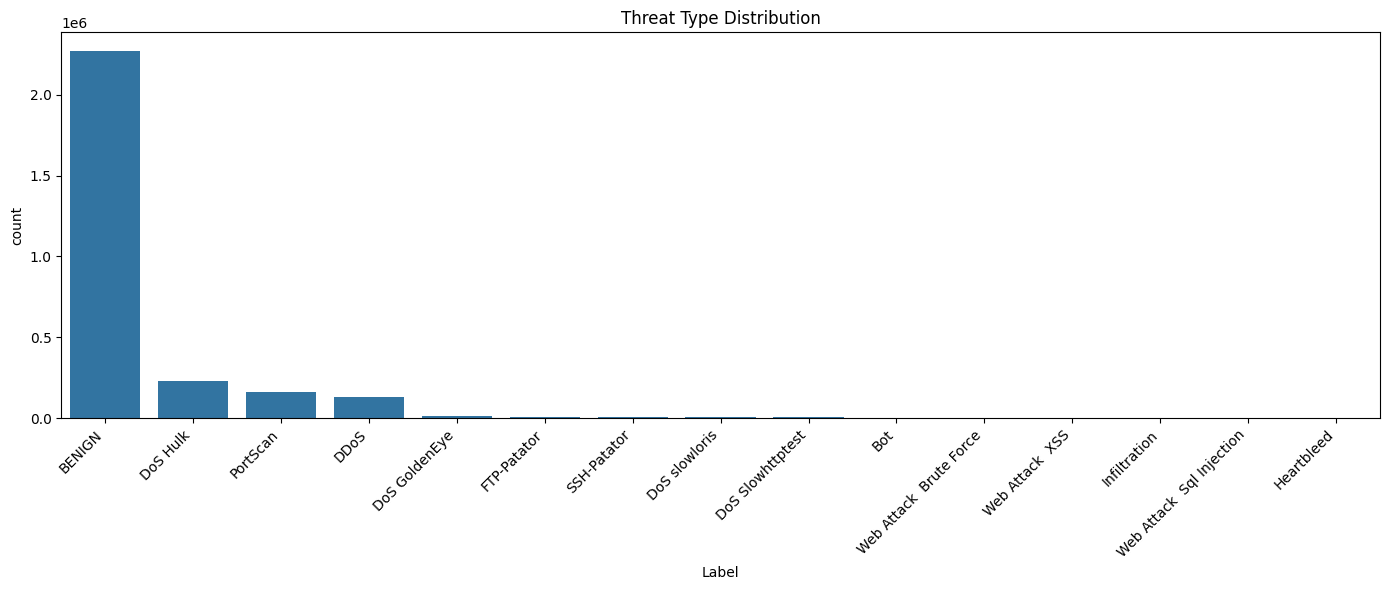

In [7]:
#Count plot
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='Label', order=df['Label'].value_counts().index)
plt.title("Threat Type Distribution")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig("label_distribution_cleaned.png")
plt.show()

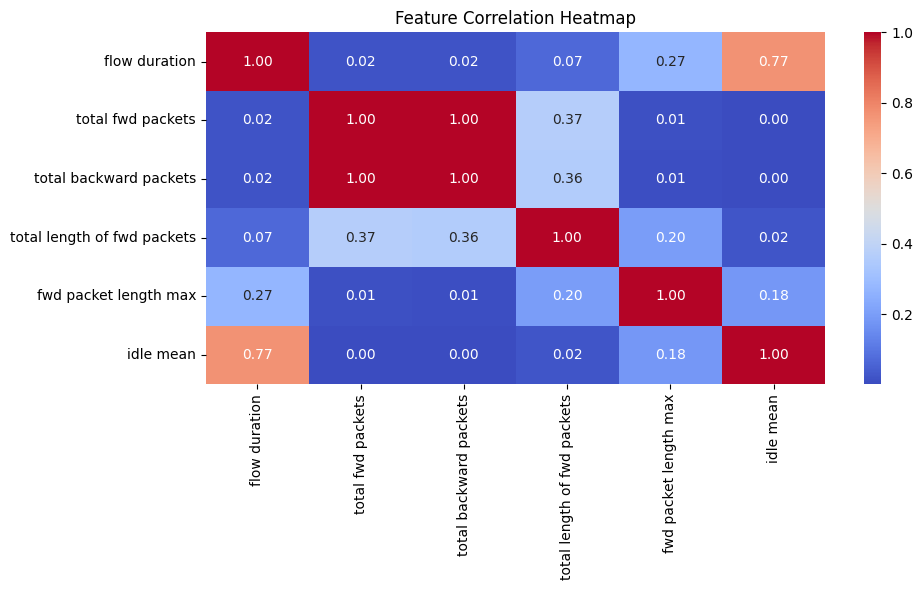

In [8]:
#Correlation HeatMap
plt.figure(figsize=(10, 6))
corr = df.drop(columns=['Label']).corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()


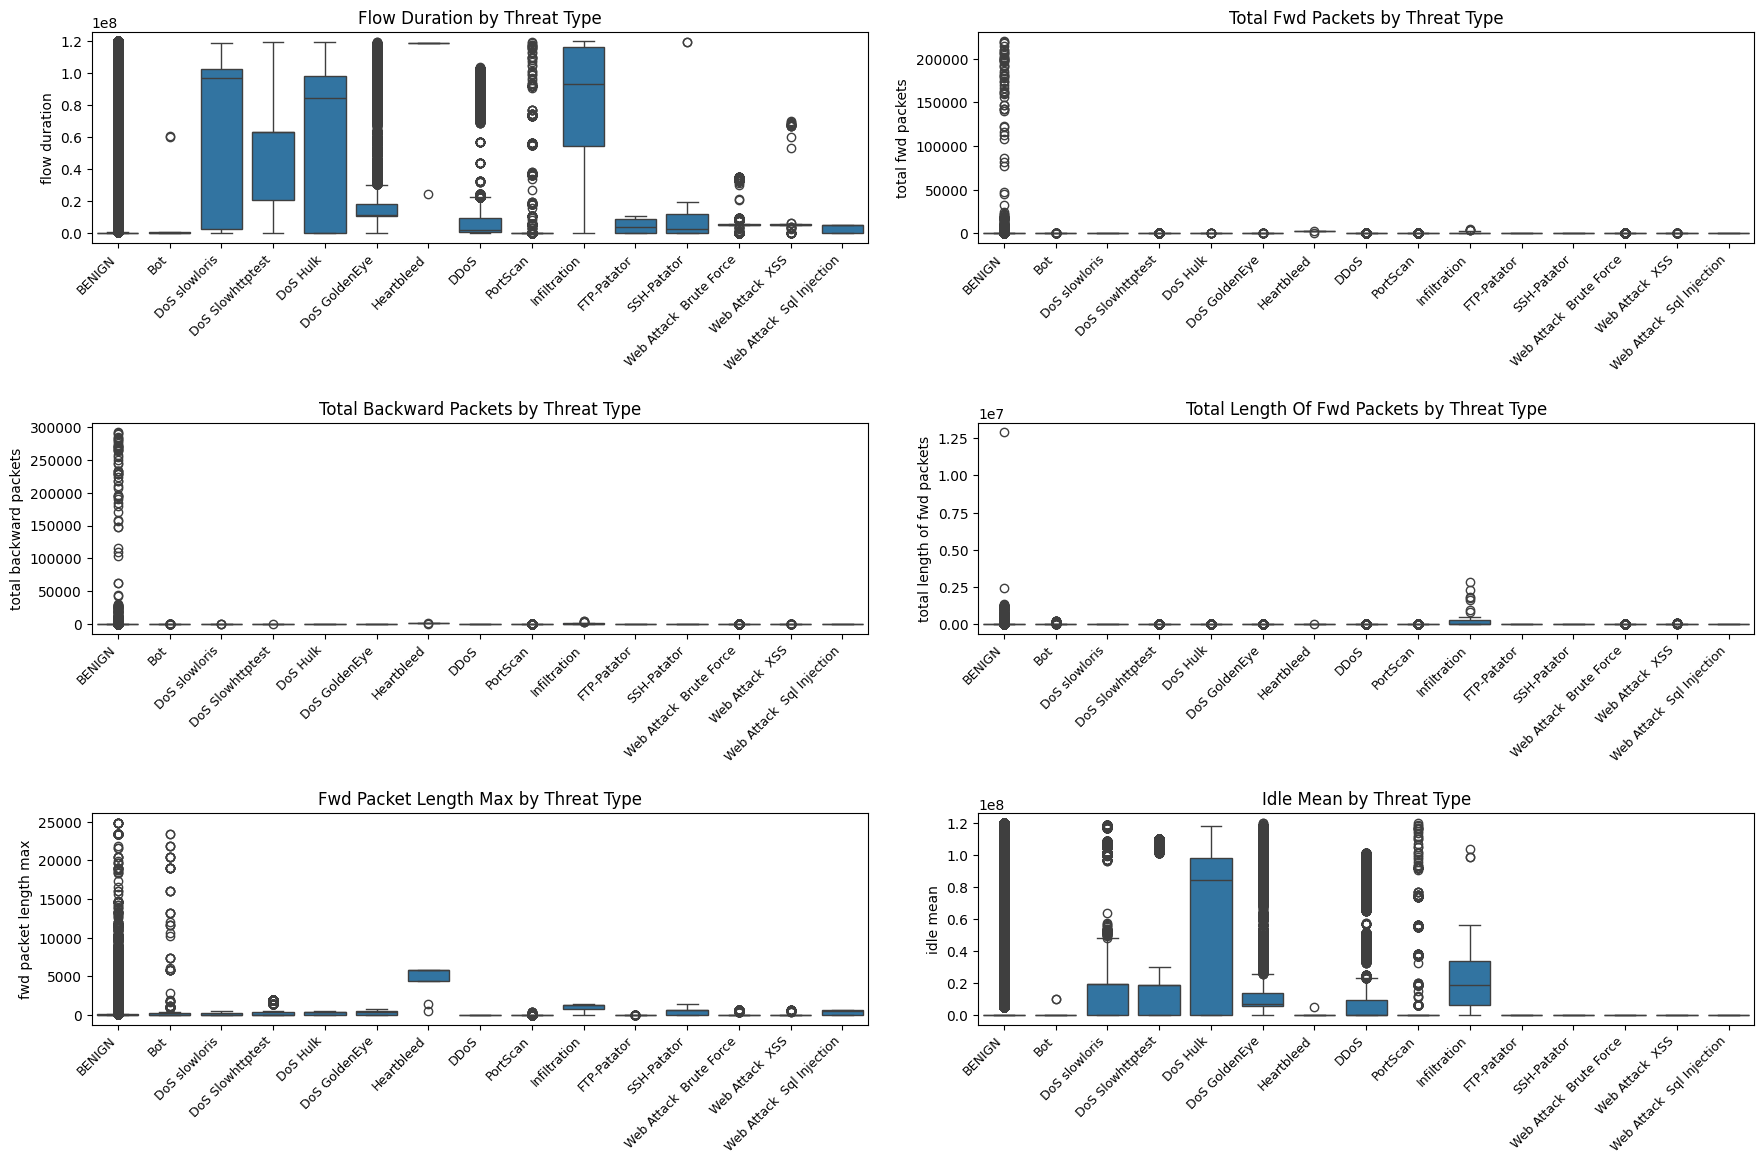

In [9]:
#Box Plot
features_to_plot = [
    'flow duration',
    'total fwd packets',
    'total backward packets',
    'total length of fwd packets',
    'fwd packet length max',
    'idle mean'
]

plt.figure(figsize=(18, 12))

for idx, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, idx)
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f"{feature.title()} by Threat Type", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.xlabel("")

plt.tight_layout(pad=2.0)
plt.savefig("combined_boxplots_fixed.png", dpi=300)
plt.show()


In [11]:
# Mean of each feature per label
stats = df.groupby('Label').mean(numeric_only=True)
print(stats)
stats.to_csv("threat_stats.csv")

                           flow duration  total fwd packets  \
Label                                                         
BENIGN                      1.122082e+07          10.654173   
Bot                         3.509427e+05           3.193795   
DDoS                        1.695559e+07           4.472439   
DoS GoldenEye               2.312722e+07           5.904401   
DoS Hulk                    5.708173e+07           5.279656   
DoS Slowhttptest            5.771989e+07           5.741771   
DoS slowloris               5.655437e+07           6.337129   
FTP-Patator                 4.513245e+06           5.496977   
Heartbleed                  1.106797e+08        2583.727273   
Infiltration                7.840772e+07         830.222222   
PortScan                    8.282023e+04           1.017580   
SSH-Patator                 6.168967e+06          11.124979   
Web Attack  Brute Force     6.506182e+06          12.371599   
Web Attack  Sql Injection   2.870398e+06           3.04

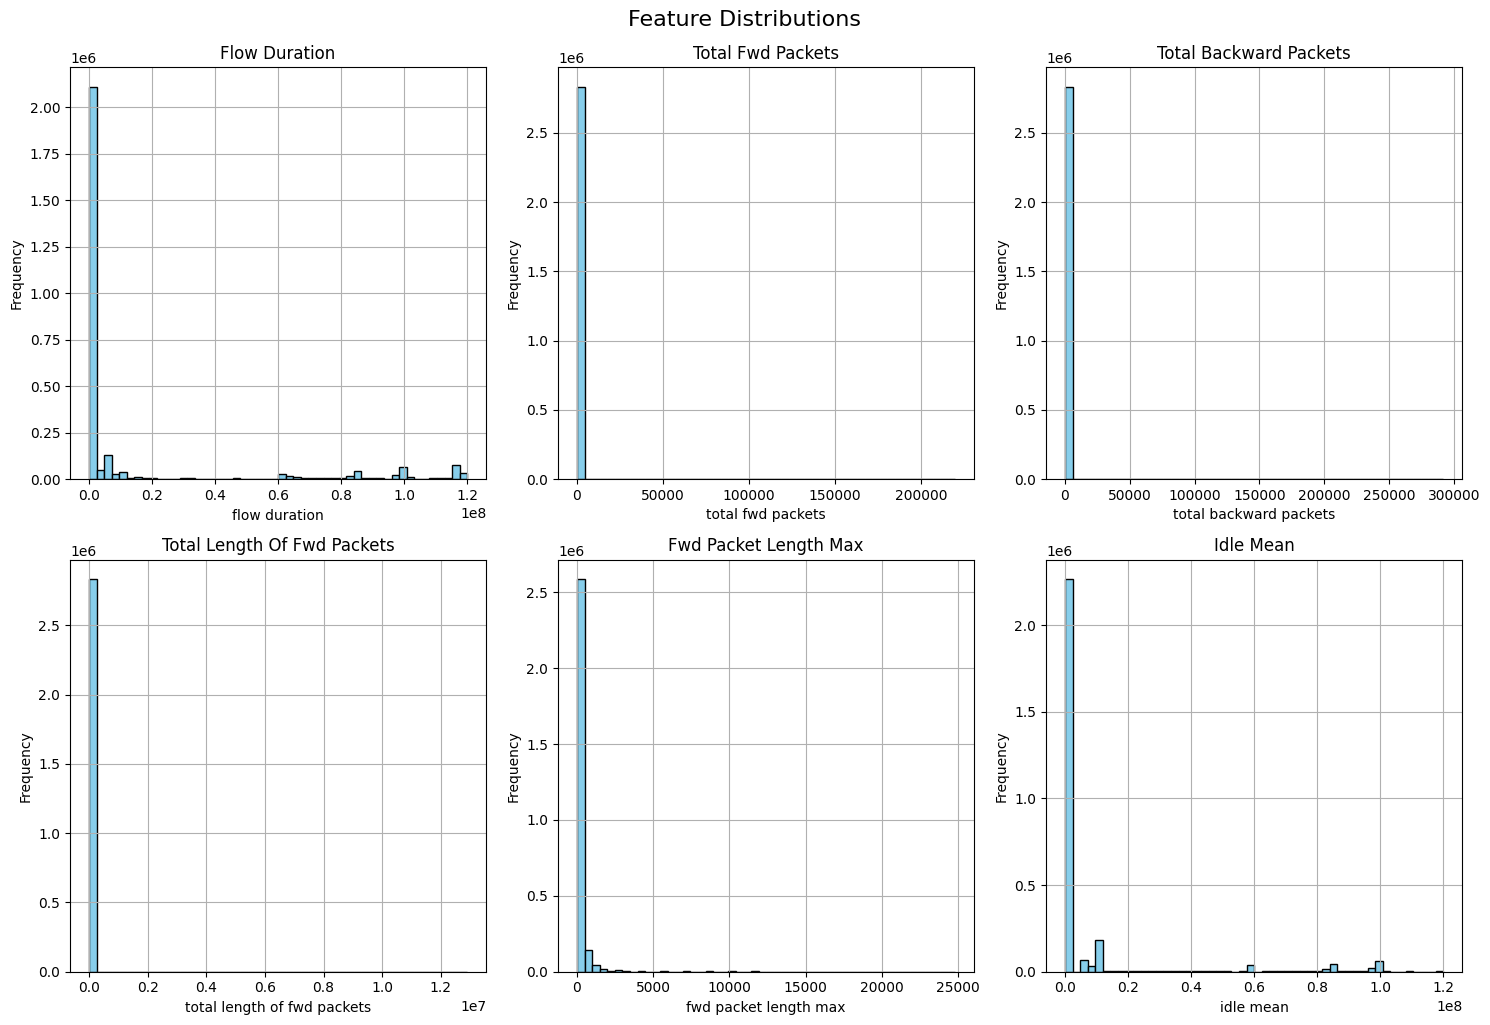

In [12]:
#Histograms
features_to_plot = [
    'flow duration',
    'total fwd packets',
    'total backward packets',
    'total length of fwd packets',
    'fwd packet length max',
    'idle mean'
]

# Plot all histograms in one grid
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    df[feature].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{feature.title()}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()

plt.suptitle("Feature Distributions", fontsize=16, y=1.02)
plt.savefig("histogram_grid_features.png", bbox_inches='tight', dpi=300)
plt.show()


In [13]:
!pip install imbalanced-learn

Label Encoding

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels
import joblib

df = pd.read_csv("cleaned_combined_dataset.csv")
df.columns = df.columns.str.strip().str.lower()

#Filter labels with ≥100 samples
label_counts = df['label'].value_counts()
valid_labels = label_counts[label_counts >= 100].index
filtered_df = df[df['label'].isin(valid_labels)].copy()

#Encode labels
le = LabelEncoder()
filtered_df['encoded_label'] = le.fit_transform(filtered_df['label'])

sample_df = filtered_df.groupby('encoded_label', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 10000), random_state=42)
).reset_index(drop=True)

#Select features
selected_features = [
    'flow duration', 'total fwd packets', 'total backward packets',
    'total length of fwd packets', 'fwd packet length max', 'idle mean'
]
X = sample_df[selected_features]
y = sample_df['encoded_label']

#Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Define models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(
        max_iter=1000, solver='lbfgs', multi_class='multinomial', class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

model_accuracies = {}
best_model = None
best_model_name = ""
best_accuracy = 0

#Train & evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    model_accuracies[name] = acc
    print(f"Accuracy: {acc:.4f}")

    used_labels = sorted(unique_labels(y_test, y_pred))
    used_class_names = le.inverse_transform(used_labels)

    print(classification_report(
        y_test, y_pred, labels=used_labels,
        target_names=used_class_names, zero_division=0
    ))

    if acc > best_accuracy:
        best_model = model
        best_model_name = name
        best_accuracy = acc

#Save model and encoder
joblib.dump(best_model, "cyber_threat_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(model_accuracies, "model_accuracies.pkl")

#Save accuracy results
accuracy_df = pd.DataFrame([
    {"Model": model, "Accuracy": round(score * 100, 2)}
    for model, score in model_accuracies.items()
]).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

accuracy_df.to_csv("model_accuracies.csv", index=False)

print(f"\n Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
print("All Accuracies:")
print(accuracy_df)


/tmp/ipython-input-14-301913994.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = filtered_df.groupby('encoded_label', group_keys=False).apply(



Training Random Forest...
Accuracy: 0.9122
                          precision    recall  f1-score   support

                  BENIGN       0.96      0.88      0.92      2000
                     Bot       0.97      0.99      0.98      2000
                    DDoS       1.00      1.00      1.00      2000
           DoS GoldenEye       0.99      0.99      0.99      2000
                DoS Hulk       0.97      0.99      0.98      2000
        DoS Slowhttptest       0.99      0.99      0.99      2000
           DoS slowloris       0.99      0.99      0.99      2000
             FTP-Patator       1.00      1.00      1.00      2000
                PortScan       0.79      0.90      0.84      2000
             SSH-Patator       0.85      0.84      0.85      2000
Web Attack � Brute Force       0.70      0.64      0.67      2000
        Web Attack � XSS       0.73      0.73      0.73      2000

                accuracy                           0.91     24000
               macro avg      

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.5218
                          precision    recall  f1-score   support

                  BENIGN       0.39      0.08      0.14      2000
                     Bot       0.22      0.37      0.27      2000
                    DDoS       0.89      0.37      0.53      2000
           DoS GoldenEye       0.83      0.62      0.71      2000
                DoS Hulk       0.88      0.58      0.70      2000
        DoS Slowhttptest       0.90      0.76      0.82      2000
           DoS slowloris       0.62      0.47      0.53      2000
             FTP-Patator       0.49      0.51      0.50      2000
                PortScan       0.44      0.99      0.61      2000
             SSH-Patator       0.82      0.49      0.61      2000
Web Attack � Brute Force       0.40      0.05      0.08      2000
        Web Attack � XSS       0.36      0.97      0.53      2000

                accuracy                           0.52     24000
               macro avg       0.60      0.52      0.50  

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9040
                          precision    recall  f1-score   support

                  BENIGN       0.98      0.88      0.93      2000
                     Bot       0.97      1.00      0.99      2000
                    DDoS       1.00      1.00      1.00      2000
           DoS GoldenEye       0.99      1.00      0.99      2000
                DoS Hulk       0.97      0.99      0.98      2000
        DoS Slowhttptest       0.99      0.99      0.99      2000
           DoS slowloris       0.99      0.99      0.99      2000
             FTP-Patator       1.00      1.00      1.00      2000
                PortScan       0.79      0.90      0.84      2000
             SSH-Patator       0.85      0.85      0.85      2000
Web Attack � Brute Force       0.69      0.48      0.57      2000
        Web Attack � XSS       0.64      0.78      0.70      2000

                accuracy                           0.90     24000
               macro avg       0.90      0.90      0.90  

In [15]:
accuracy_df = pd.DataFrame(
    list(model_accuracies.items()),
    columns=["Model", "Accuracy"]
)

accuracy_df["Accuracy (%)"] = (accuracy_df["Accuracy"] * 100).round(2)

accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

print(accuracy_df)

accuracy_df.to_csv("model_accuracy_table.csv", index=False)


                 Model  Accuracy  Accuracy (%)
0        Random Forest  0.912208         91.22
1        Decision Tree  0.910625         91.06
2                  KNN  0.909458         90.95
3              XGBoost  0.904000         90.40
4  Logistic Regression  0.521792         52.18


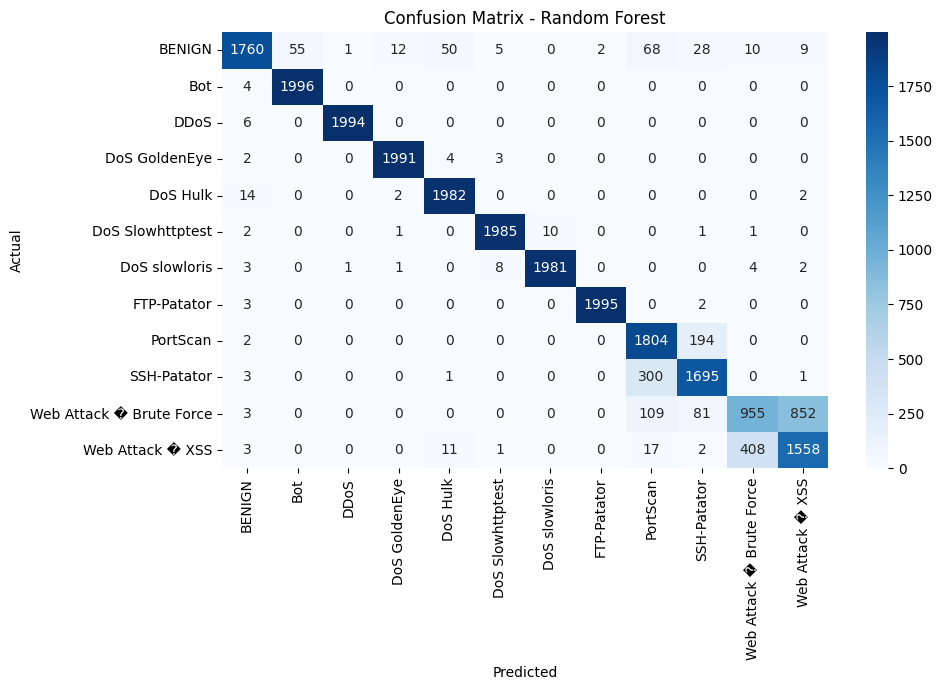

In [16]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig("confusion_matrix.png"
)
plt.show()


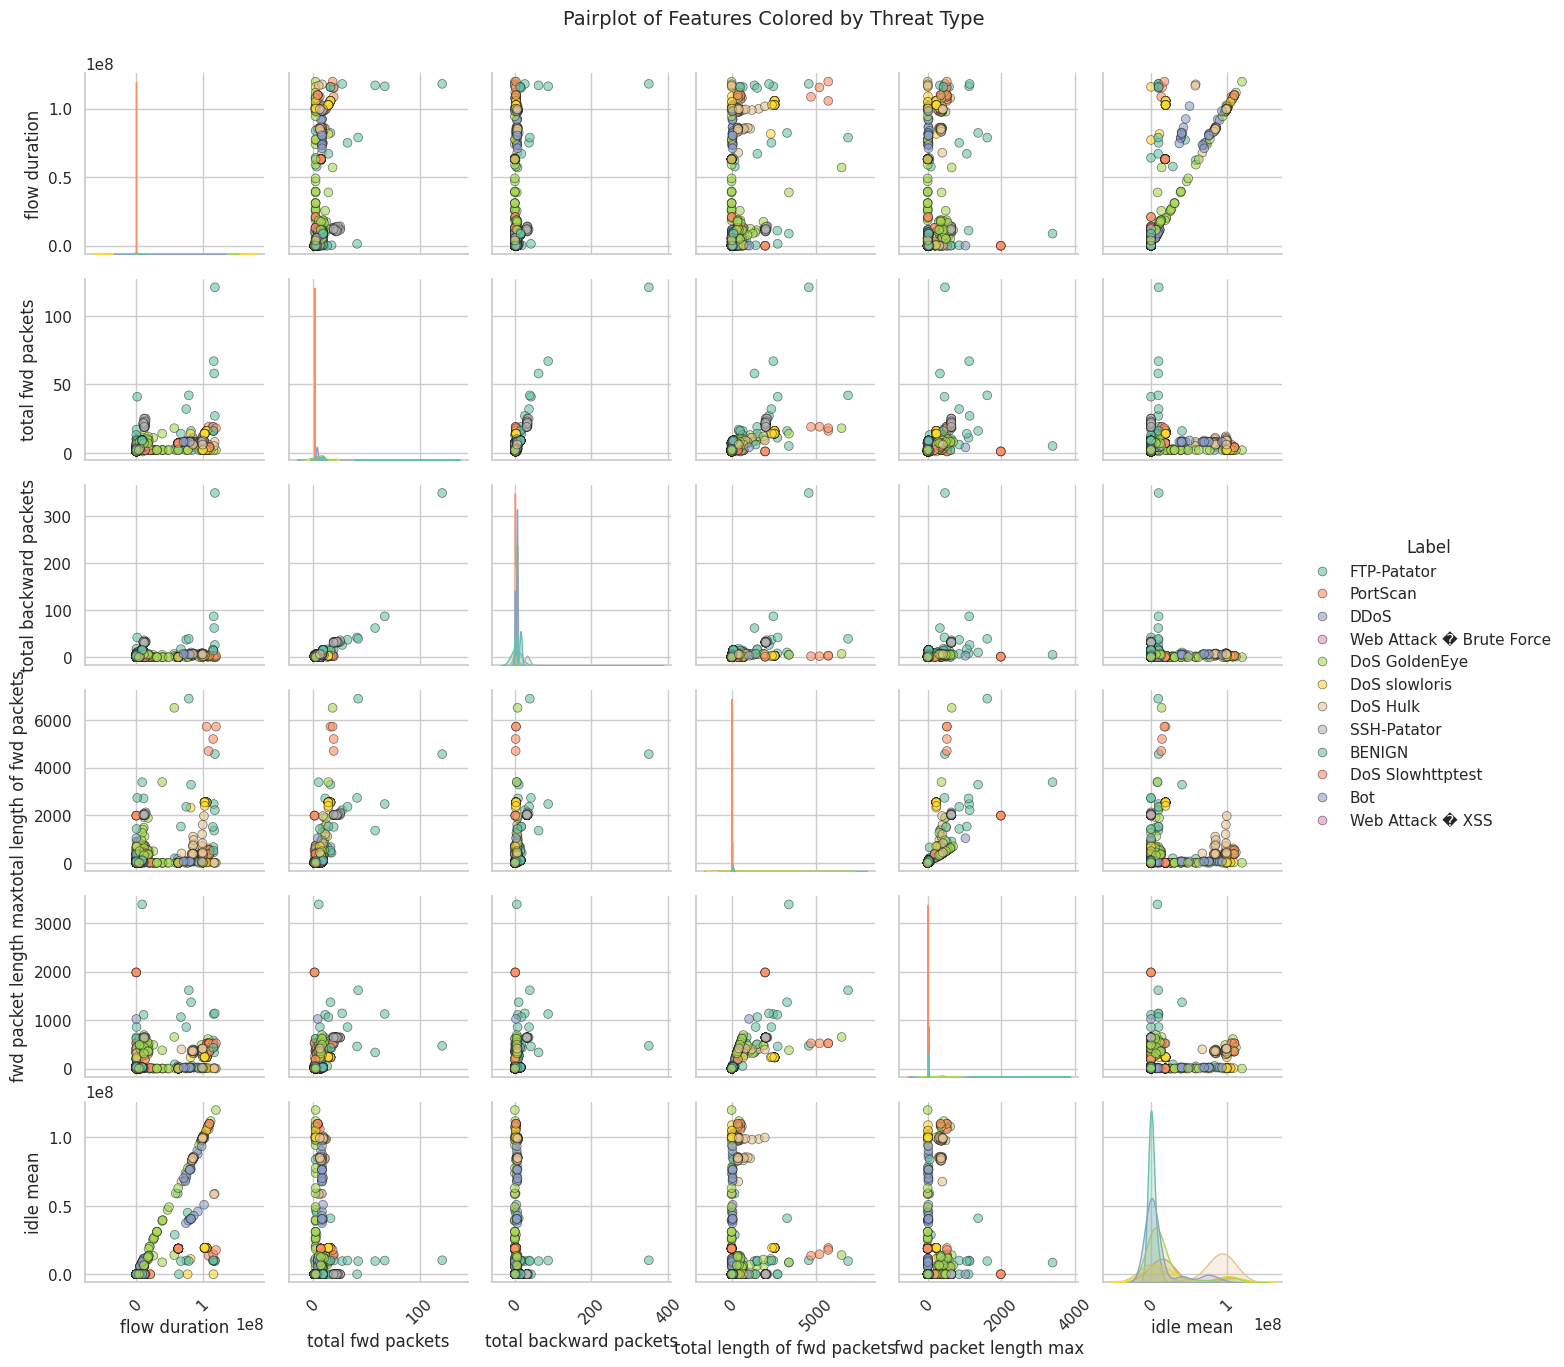

In [17]:
pair_df = sample_df.copy()
pair_df['Label'] = le.inverse_transform(pair_df['encoded_label'])

features_for_pairplot = [
    'flow duration',
    'total fwd packets',
    'total backward packets',
    'total length of fwd packets',
    'fwd packet length max',
    'idle mean',
    'Label'
]

sns_df = pair_df[features_for_pairplot].sample(n=1000, random_state=42)

sns.set(style="whitegrid")
pair_plot = sns.pairplot(
    sns_df,
    hue="Label",
    palette="Set2",
    diag_kind="kde",
    plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'},
    height=2.2
)

#Rotate tick labels using tick_params
for ax in pair_plot.axes.flatten():
    if ax is not None:
        ax.tick_params(axis='x', labelrotation=45)
        ax.tick_params(axis='y', labelrotation=0)

pair_plot.fig.suptitle("Pairplot of Features Colored by Threat Type", y=1.02, fontsize=14)
plt.savefig("pairplot_fixed_labels.png", dpi=300, bbox_inches='tight')
plt.show()


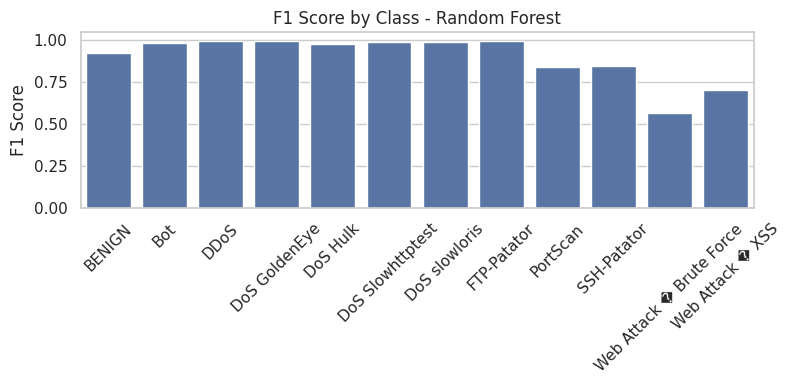

In [18]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average=None)
plt.figure(figsize=(8, 4))
sns.barplot(x=le.inverse_transform(sorted(set(y_test))), y=f1)
plt.title(f'F1 Score by Class - {best_model_name}')
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("f1_score.png")
plt.show()


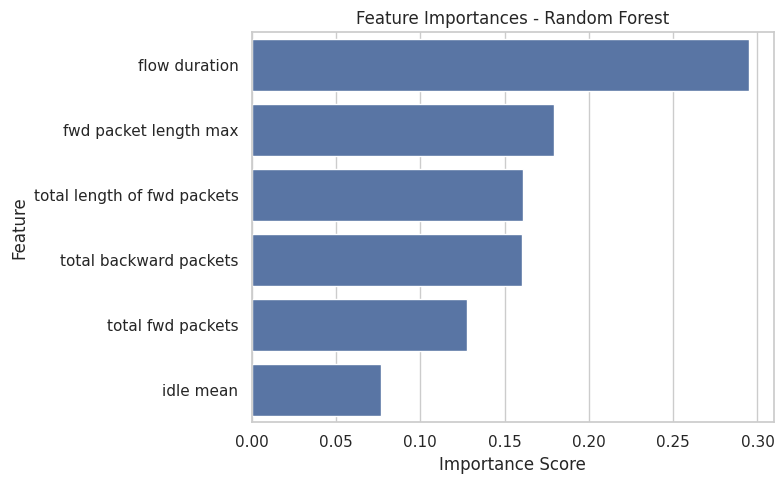

In [19]:
# Plot feature importance
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = np.array(X.columns)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[indices], y=feature_names[indices])
    plt.title(f'Feature Importances - {best_model_name}')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig("feature_importance.png", dpi=300)
    plt.show()



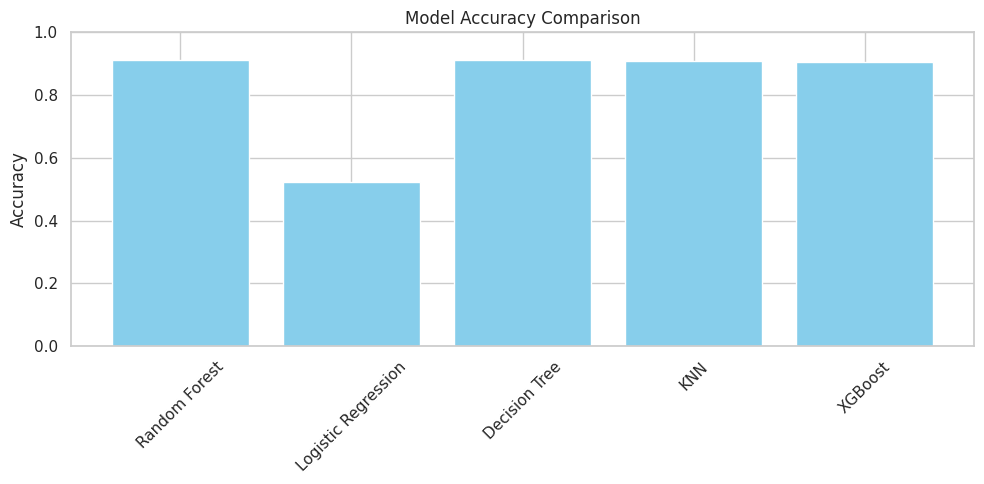

In [20]:
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png", dpi=300)
plt.show()
